In [1]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')
    return HTML(styles.text)
css_styling()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['animation.html'] = 'html5'

# Finite Volume Implementation

We will be integrating the following equation on a finite-volume scheme:

$$ \frac{\partial \phi}{\partial t} = -\frac{\partial F}{\partial x} $$

where $F = u\phi$.

$$\int^{t_{n+1}}_{t_{n}} \int^{e}_{w} \frac{\partial \phi }{\partial t} dxdt\  =\  -\int^{t_{n+1}}_{t_{n}} \int^{e}_{w} \frac{\partial F}{\partial x} dxdt $$

If we define:

$$\tilde{\phi } =\frac{1}{\Delta x} \int^{e}_{w} \phi dx$$

then the equation becomes:

$$\int^{t_{n+1}}_{t_{n}} \frac{\partial \tilde{\varphi } }{\partial t} \Delta xdt=-\int^{t_{n+1}}_{t_{n}} \left( F_{e}-F_{w}\right)  dt $$

$$\tilde{\varphi }^{n+1} -\tilde{\varphi }^{n} =-\frac{\bigtriangleup t}{\bigtriangleup x} \left( \tilde{F}_{e} -\tilde{F}_{w} \right)  $$

where

$$\tilde{F} =\frac{1}{\Delta t} \int^{t_{n+1}}_{t_{n}} Fdt$$

To implement the midpoint rule as an integrator, we will use a predictor-corrector method to get the flux at $t=n+\frac{1}{2}$

In [3]:
def step(x, x0):
    x0 = 0.6
    x1 = 0.8
    result = x - x0
    result[x-x1<x1] = 1.
    result[x<x0] = 0.
    result[x>x1] = 0.
    return result

In [4]:
x = np.linspace(0, 1, 20)

In [5]:
step_x = step(x, 0.6)

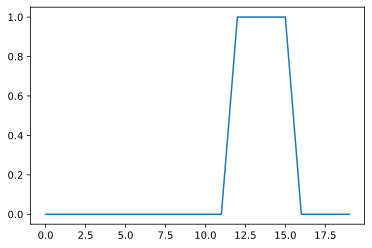

In [6]:
plt.plot(step_x)

In [20]:
def gaussian(x, x0):
    s = 0.08
    s = s**2
    result = np.exp(-(x-x0)**2/s)
    return result

In [21]:
gauss_x = gaussian(x, 0.6)

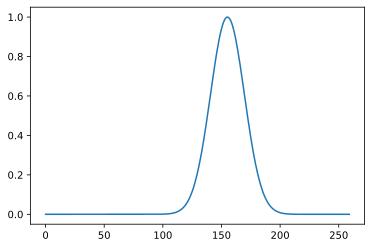

In [22]:
plt.plot(gauss_x)

In [23]:
L = 1.   # Domain length
n = 256  # Number of cell-centered points (intervals)
dx = L/n
x = np.linspace(-3/2*dx, L+3/2*dx, n+4) # need 2 ghost cells per side

In [24]:
# Create solution arrays
ϕ = np.zeros(n+4)
flux = np.zeros(n+4+1)  # One more edge for fluxes than cells
x0 = 0.3
phi0 = gaussian(x, x0) + step(x, x0)

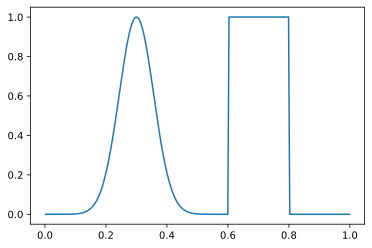

In [27]:
plt.plot(x[2:-2], phi0[2:-2])

In [28]:
cfl = 0.5
c = 1.     # constant speed
dt = cfl*dx/c
print(f'dt = {dt}')

dt = 0.001953125


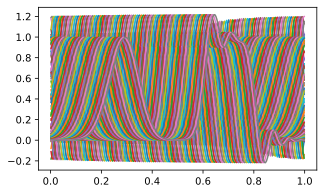

In [41]:
# the k-scheme
k = -1   # upwind
t = 0
tend = L/c

# Make arrays for animation
sol = []
sol.append(phi0)
ims = []

fig = plt.figure(figsize=[5,3], dpi=200)
plt.plot(x[2:-2], phi0[2:-2], 'darkred', animated=True)
i = 0
while t < tend:
    phin = sol[-1]
    
    # periodic BCs
    phin[-2] = phin[2]
    phin[-1] = phin[3]
    phin[0] = phin[-4]
    phin[1] = phin[-3]
    
    if i%4 == 0:
        im = plt.plot(x[2:-2], phin[2:-2], animated=True)
        ims.append(im)
    
    # create a temporary array to store predictor
    phi = np.zeros_like(phi0)
    # predictor - take a half step and use upwind
    # du/dt = -cdu/dx
    if c >= 0 :
        ϕc = phin[1:-2]
    else:
        ϕc = phin[2:-1]
        
    flux[2:-2] = c*ϕc  # Interior cells
    phi[2:-2] = phin[2:-2] - dt/2./dx*(flux[3:-2]-flux[2:-3]) # flux_e - flux_w for all interior cells
    # periodic BCs
    phi[-2] = phi[2]
    phi[-1] = phi[3]
    phi[0] = phi[-4]
    phi[1] = phi[-3]
    
    # du/dt = -c*du/dx
    if c >= 0:
        ϕc = phi[1:-2] # phi upwind
        ϕu = phi[:-3]  # phi far upwind
        ϕd = phi[2:-1] # phi downwind
    else:
        ϕc = phi[2:-1] # phi upwind
        ϕu = phi[3:]   # phi far upwind
        ϕd = phi[1:-1] # phi downwind
    
    flux[2:-2] = ϕc + (1-k)/4.*(ϕc-ϕu) + (1+k)/4.*(ϕd-ϕc)
    flux = c*flux
    # advect
    phi[2:-2] = phin[2:-2] - c*dt/dx*(flux[3:-2]-flux[2:-3]) # dt/dx/dx*diffusion
    i += 1
    t += dt
    sol.append(phi)
    
ani = animation.ArtistAnimation(fig, ims, interval=100)

In [42]:
ani

In [39]:
len(ϕc)

257

In [40]:
len(flux)

261